# Full example of adaptive setpoint temperature simulation: IBPSA webinar

**Please, note: this Notebook was used as a case study in the IBPSA Webinar (https://www.youtube.com/watch?v=PQ34Pl7t4HA). However, in that webinar it was adapted to accim version 0.7.1. This Notebook has been updated to suit the latest version of accim.**

In this section, we're going to run a simulation with adaptive setpoint temperatures. Say we want to run some simulations using a [Brazilian local comfort model](https://linkinghub.elsevier.com/retrieve/pii/S0378778817331079) developed by Ricardo Forgiarini Rupp et al [1] in some locations in Brazil, and also we want to **analyse and visualize the data**. First of all, given EnergyPlus (any version between 9.1 and 23.1 included) is installed, and accim has been installed by entering 'pip install accim' in the CMD terminal, let's prepare the files we need: the IDF(s) and the EPW(s). Let's see what file we have in the folder and then we'll continue with the IDF(s).

[1] R.F. Rupp, R. de Dear, E. Ghisi, Field study of mixed-mode office buildings in Southern Brazil using an adaptive thermal comfort framework, Energy and Buildings. 158 (2018) 1475–1486. https://doi.org/10.1016/j.enbuild.2017.11.047.

In [1]:
from os import listdir
input_files = [i for i in listdir()]
print(*input_files, sep='\n')

.ipynb_checkpoints
backup
Current_GC07_Chapeco.epw
Current_GC20_Palmas.epw
full_example_IBPSA.ipynb
RCP852100_GC07_Chapeco.epw
RCP852100_GC20_Palmas.epw
TestModel.idf
__init__.py


The building energy model used is a simple 2-zone model done in DesignBuilder with all parameters by default. We only set the natural ventilation to calculated, and allowed natural ventilation in the HVAC tab for the 2 zones. If you want to have a look at the IDF, you can load it in [Ladybug's Spider IDF Viewer](https://www.ladybug.tools/spider-2020/spider-idf-viewer/v-2020-10-09/spider-idf-viewer.html).

At this point, the methodology is composed of the following sections and subsections:
- __1. Data pre-processing__

    - __1.1. Implementing ACCIS__
    
    - __1.2. Preparing EPW files__
    
- __2. Running simulations__

- __3. Data post-processing__

    - __3.1 Visualizing the data__
    
    - __3.2 Analysing the data__
     
 
 Useful links:
 - Web repository: https://github.com/dsanchez-garcia/accim
 - Documentation: https://accim.readthedocs.io/en/master/
 - Project at Python Package Index: https://pypi.org/project/accim/

## 1. Data pre-processing

### 1.1. Implementing ACCIS (using `addAccis()`)

Say we have one or multiple IDF files, with an existing HVAC system (in this case, the use of mixed-mode ScriptType 'ex_mm' is not recommended; only full air-conditioning) or with no HVAC system at all (in this case, any of the 'vrf_ac' or 'vrf_mm' ScriptTypes are recommended). In this example, we are going to use an IDF without HVAC system, and we are going to use 'vrf_mm' so that accim adds a generic VRF system.

Let's see what IDFs we do have in our folder:

In [2]:
input_idfs = [i for i in listdir() if i.endswith('.idf')]
print(input_idfs)

['TestModel.idf']


So now, we're going to generate building energy models with setpoint temperatures based on the Brazilian comfort model (i.e. ComfStand takes the value 15). We're going to select the 80% acceptability levels (i.e. CAT takes the value 80), and we're going to select the setpoint behaviour to horizontally extend the setpoint temperatures (or comfort limits) when applicability limits are exceeded (i.e. ComfMod takes the value 3), and the fully static setpoint temperatures (i.e. ComfMod takes the value 0). There are 2 methods to apply adaptive setpoint temperatures:
- Short method, which is running the following to lines of code:
```
from accim.sim import accis
accis.addAccis()
```

When we run the 2 lines of code above, accim is going to ask us to enter some information it needs to generate the output IDFs. The data we're going to input, in the same order, is:
- Enter the ScriptType: **vrf_mm**
- Enter the SupplyAirTempInputMethod: **temperature difference**
- Do you want to keep the existing outputs (true or false)?: **false**
- Enter the Output type (standard, simplified or detailed): **standard**
- Enter the Output frequencies separated by space (timestep, hourly, daily, monthly, runperiod): **hourly**
- Enter the EnergyPlus version (9.1 to 23.1): **23.1**
- Enter the Temperature Control method (temperature or pmv): **temperature**

After that, accim will let us know the information we have entered, and it will start the generic IDF generation process. Lots of actions are going to be performed, and all of them will be printed on screen. Once this process is done, accim will let us know if any of the IDFs is not going to work for any reason, and then it will start the output IDF files generation process. Then, accim will ask us again to enter some information, this time to generate the output IDF(s). The data we are going to enter now is:

- Enter the Comfort Standard numbers separated by space: **15**
- Enter the Category numbers separated by space: **80**
- Enter the Comfort Mode numbers separated by space: **0 3** (where 0 and 3 are respectively static and adaptive setpoints)
- Enter the HVAC Mode numbers separated by space: **1 2** (in this case we have also selected 1 for naturally ventilated, to see the difference with mixed-mode)
- Enter the Ventilation Control numbers separated by space: **0**

For all the remaining arguments, we're going to hit enter to omit it and take the default value. Finally, accim will let us know the list of output IDFs and will ask for confirmation to proceed:

- Do you still want to run ACCIS? [y/n]: **y**

Alternatively, we could specify all the arguments when calling the function, as shown in the cell below. You can find the definition and explanation of the arguments in documentation's [Detailed use section](https://accim.readthedocs.io/en/latest/4_detailed%20use.html#), and the values for the adaptive setpoints in the [full setpoint temperatures table](https://htmlpreview.github.io/?https://github.com/dsanchez-garcia/accim/blob/master/accim/docs/html_files/full_setpoint_table.html)

In [3]:
from accim.sim import accis
add_accis_instance = accis.addAccis(
    ScriptType='vrf_mm',
    SupplyAirTempInputMethod='temperature difference',
    Output_keep_existing=False,
    Output_type='standard',
    Output_freqs=['hourly'],
    EnergyPlus_version='23.1',
    TempCtrl='temperature',
    ComfStand=[15],
    CAT=[80],
    ComfMod=[0, 3],
    SetpointAcc=1000,
    HVACmode=[1, 2],
    VentCtrl=[0],
    VSToffset=[0],
    MinOToffset=[50],
    MaxWindSpeed=[50],
    ASTtol_steps=0.1,
    ASTtol_start=0.1,
    ASTtol_end_input=0.1,
    confirmGen=True
)


--------------------------------------------------------
Adaptive-Comfort-Control-Implemented Model (ACCIM) v0.7.1
--------------------------------------------------------

This tool allows to apply adaptive setpoint temperatures. 
For further information, please read the documentation: 
https://accim.readthedocs.io/en/master/
For a visual understanding of the tool, please visit the following jupyter notebooks:
-    Using addAccis() to apply adaptive setpoint temperatures
https://accim.readthedocs.io/en/master/jupyter_notebooks/addAccis/using_addAccis.html
-    Using rename_epw_files() to rename the EPWs for proper data analysis after simulation
https://accim.readthedocs.io/en/master/jupyter_notebooks/rename_epw_files/using_rename_epw_files.html
-    Using runEp() to directly run simulations with EnergyPlus
https://accim.readthedocs.io/en/master/jupyter_notebooks/runEp/using_runEp.html
-    Using the class Table() for data analysis
https://accim.readthedocs.io/en/master/jupyter_notebo

Added - Site Outdoor Air Drybulb Temperature Reporting FrequencyHourly Output:Variable data
Added - Site Wind Speed Reporting FrequencyHourly Output:Variable data
Added - Site Outdoor Air Relative Humidity Reporting FrequencyHourly Output:Variable data
Added - AHST_Sch_BLOCK1_ZONE2 Reporting FrequencyHourly Output:Variable data
Added - ACST_Sch_BLOCK1_ZONE2 Reporting FrequencyHourly Output:Variable data
Added - AHST_Sch_BLOCK1_ZONE1 Reporting FrequencyHourly Output:Variable data
Added - ACST_Sch_BLOCK1_ZONE1 Reporting FrequencyHourly Output:Variable data
Added - VRF Heat Pump Cooling Electricity Energy Reporting FrequencyHourly Output:Variable data
Added - VRF Heat Pump Heating Electricity Energy Reporting FrequencyHourly Output:Variable data
Added - BLOCK1_ZONE2 VRF Indoor Unit DX Cooling Coil Reporting FrequencyHourly Output:Variable data
Added - BLOCK1_ZONE2 VRF Indoor Unit DX Heating Coil Reporting Frequency Hourly Output:Variable data
Added - BLOCK1_ZONE1 VRF Indoor Unit DX Coolin

So, now let's see the list of output IDFs we have generated

In [4]:
output_idfs = [i for i in listdir() if i.endswith('.idf') and i not in input_idfs]
print(*output_idfs, sep='\n')

TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf


Now, let's have a look at the internal variables which have been stored in the ``addAccis`` instance we have done:

In [5]:
[i for i in dir(add_accis_instance) if '__' not in i]

['arguments',
 'input_idfs',
 'occupied_zones',
 'occupied_zones_original_name',
 'output_idfs',
 'windows_and_doors',
 'windows_and_doors_original_name']

For instance, in arguments, you can see the arguments you have previously specified.

In [6]:
add_accis_instance.arguments

{'ScriptType': 'vrf_mm',
 'SupplyAirTempInputMethod': 'temperature difference',
 'Output_type': 'standard',
 'Output_freqs': ['hourly'],
 'Output_keep_existing': False,
 'Output_gen_dataframe': None,
 'Output_take_dataframe': None,
 'EnergyPlus_version': '23.1',
 'TempCtrl': 'temperature',
 'ComfStand': [15],
 'CAT': [80],
 'ComfMod': [0, 3],
 'SetpointAcc': 1000,
 'CoolSeasonStart': 121,
 'CoolSeasonEnd': 274,
 'HVACmode': [1, 2],
 'VentCtrl': [0],
 'MaxTempDiffVOF': 20,
 'MinTempDiffVOF': 0.5,
 'MultiplierVOF': 0.25,
 'VSToffset': [0],
 'MinOToffset': [50],
 'MaxWindSpeed': [50],
 'ASTtol_start': 0.1,
 'ASTtol_end_input': 0.1,
 'ASTtol_steps': 0.1,
 'NameSuffix': '',
 'verboseMode': True,
 'confirmGen': True}

In variables  ``occupied_zones``, ``occupied_zones_original_name``, ``windows_and_doors`` and
 ``windows_and_doors_original_name`` you can see the zones and windows and doors within the input idfs:

In [7]:
add_accis_instance.occupied_zones

{'TestModel': ['BLOCK1_ZONE2', 'BLOCK1_ZONE1']}

In [8]:
add_accis_instance.windows_and_doors

{'TestModel': ['Block1_Zone2_Wall_3_0_0_0_0_0_Win',
  'Block1_Zone2_Wall_4_0_0_0_0_0_Win',
  'Block1_Zone2_Wall_5_0_0_0_0_0_Win',
  'Block1_Zone1_Wall_2_0_0_0_0_0_Win',
  'Block1_Zone1_Wall_3_0_0_0_0_0_Win',
  'Block1_Zone1_Wall_5_0_0_0_0_0_Win']}

In variables ``input_idfs`` and ``output_idfs`` you can inspect the input and output idfs using [eppy](https://pypi.org/project/eppy/#description):

In [9]:
add_accis_instance.input_idfs

{'TestModel': <eppy.modeleditor.IDF at 0x236703bb400>}

Now, let's see the variable ``output_idfs`` 

In [12]:
add_accis_instance.output_idfs

{'TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf': <eppy.modeleditor.IDF at 0x236703bb3a0>,
 'TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf': <eppy.modeleditor.IDF at 0x236703bb3a0>,
 'TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf': <eppy.modeleditor.IDF at 0x236703bb3a0>,
 'TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf': <eppy.modeleditor.IDF at 0x236703bb3a0>}

In this case, we have generated more IDFs than we need, so let's remove the others. We only want a single naturally ventilated IDF, to compare the indoor temperature with the mixed-mode IDF with adaptive setpoints. IDFs are NV when HVACmode takes the value 1.

In [14]:
idfs_to_be_removed = [i for i in listdir() if i.endswith('.idf') and 'HM_1' in i and 'CS_BRA Rupp NV[CA_80[CM_3[HM_1' not in i]
print(*idfs_to_be_removed, sep='\n')

TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf


In [15]:
from os import remove
for i in idfs_to_be_removed:
    remove(i)

Let's see what IDFs we do finally have:

In [16]:
output_idfs = [i for i in listdir() if i.endswith('.idf') and i not in input_idfs]
print(*output_idfs, sep='\n')


TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf


So, we're done with the IDFs. You can see these have been named based on the input data, separated by the character '['. Let's move to the EPWs.

### 1.2. Preparing EPW files (using `rename_epw_files()`)

Let's see the EPWs we are going to use for the simulations:

In [17]:
original_epws = [i for i in listdir() if i.endswith('.epw')]
print(*original_epws, sep='\n')

Current_GC07_Chapeco.epw
Current_GC20_Palmas.epw
RCP852100_GC07_Chapeco.epw
RCP852100_GC20_Palmas.epw


Now, we're going to rename them. We want them to follow the pattern "Country_City_RCPscenario-Year". But, why is that? Because later, when we run the simulations and read the CSV files, we will be able to analyse them considering the fields Country, City, RCPscenario and Year as categorical variables. So let's rename them running the code in the cell below.

First, accim will try to rename them based on the original name and the geolocation. If no match between those is found, accim will assign the string 'UNKNOWN' to the city. Then, accim will ask you if you want to edit some of the new names. If so, you'll need to enter the IDs:
- If any of the city or subcountry names needs some amendment (if you are not happy with any of the available options, you can exclude it from renaming at the next stage), please enter the EPW IDs separated by space:**(hit enter)**

Afterwards, you'll be asked to enter the new city name for each ID you previously entered (in this case, 0 1 2 3). So, 
- Regarding the file ID: 0 ... Please enter the amended city or subcountry, which must be unique: **Chapeco**
- Regarding the file ID: 1 ... Please enter the amended city or subcountry, which must be unique: **Palmas**
- Regarding the file ID: 2 ... Please enter the amended city or subcountry, which must be unique: **Chapeco**
- Regarding the file ID: 3 ... Please enter the amended city or subcountry, which must be unique: **Palmas**

Then, accim will let you know the old names, and the new named after amendments. Next, accim will ask you if you want to exclude some EPW from renaming. In this case, we're just going to hit enter to continue because we don't want to exclude any:
- If you want to exclude some EPWs from renaming, please enter the new names separated by space, otherwise, hit enter to continue:

Finally, accim will ask for confirmation to proceed with the renaming:
Do you want to rename the file or files? [y/n]:**y**

At this point, accim will make a copy of the EPWs and rename them. Afterwards, we would be asked if we want to delete the older EPWs. In this case, we won't because the deletion has been already set to False in the arguments.

In [18]:
from accim.data.data_preprocessing import rename_epw_files
rename_epw_files(
    rename_dict={
        'Chapeco': 'Chapeco',
        'Palmas': 'Palmas'
    },
    confirm_deletion=False
)

C:\users\sanga\appdata\local\programs\python\python39\lib\site-packages\accim\data\data_preprocessing.py:181: FutureWarning: The default value of regex will change from True to False in a future version.
  epw_df['EPW_names'] = epw_df['EPW_file_names'].str.replace('.epw', '')
C:\users\sanga\appdata\local\programs\python\python39\lib\site-packages\accim\data\data_preprocessing.py:183: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  epw_df['EPW_mod'] = epw_df['EPW_names'].str.replace('-', '_').str.replace('.', '_').str.split('_')
C:\users\sanga\appdata\local\programs\python\python39\lib\site-packages\accim\data\data_preprocessing.py:185: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


Since no match has been found between RCP scenario Year and EPW file name, Present year has been assigned to the following EPW files:
Current_GC07_Chapeco.epw
Current_GC20_Palmas.epw
The geolocation process has taken: 2.1 seconds (0.53 s/EPW)

The previous and new names of the EPW files and their unique IDs are:
ID: 0 / Current_GC07_Chapeco / Brazil_Chapeco_Present
ID: 1 / Current_GC20_Palmas / Brazil_Palmas_Present
ID: 2 / RCP852100_GC07_Chapeco / Brazil_Chapeco_RCP85-2100
ID: 3 / RCP852100_GC20_Palmas / Brazil_Palmas_RCP85-2100

If any of the city or subcountry names needs some amendment (if you are not happy with any of the available options, you can exclude it from renaming at the next stage), please enter the EPW IDs separated by space; otherwise, hit enter to omit:

The final list of previous and new names of the EPW files and their unique IDs is:
ID: 0 / Current_GC07_Chapeco / Brazil_Chapeco_Present
ID: 1 / Current_GC20_Palmas / Brazil_Palmas_Present
ID: 2 / RCP852100_GC07_Chape

``rename_epw_files`` uses OpenStreetMap to extract the address from coordinates. If you get an SSL certificate error, you might need to find a different way to rename the files. You could also proceed without renaming them, but you could only make comparisons based on the entire EPW filename. <span style="color:red">IMPORTANT: PLEASE, **ONLY** RUN THE NEXT CELL IF YOU GOT AN SSL ERROR IN THE PREVIOUS ONE:</span>

In [ ]:
import os
import shutil

for i in original_epws:
    shutil.copy(i, i.split('.epw')[0]+'_new.epw')

renaming_epws = {
    'Current_GC07_Chapeco_new.epw': 'Brazil_Chapeco_Present.epw',
    'Current_GC20_Palmas_new.epw': 'Brazil_Palmas_Present.epw',
    'RCP852100_GC07_Chapeco_new.epw': 'Brazil_Chapeco_RCP85-2100.epw',
    'RCP852100_GC20_Palmas_new.epw': 'Brazil_Palmas_RCP85-2100.epw',
}

for i in renaming_epws:
    os.rename(i, renaming_epws[i])

Now, let's see what EPWs we do have:

In [19]:
all_epws = [i for i in listdir() if i.endswith('.epw')]
print(*all_epws, sep='\n')

Brazil_Chapeco_Present.epw
Brazil_Chapeco_RCP85-2100.epw
Brazil_Palmas_Present.epw
Brazil_Palmas_RCP85-2100.epw
Current_GC07_Chapeco.epw
Current_GC20_Palmas.epw
RCP852100_GC07_Chapeco.epw
RCP852100_GC20_Palmas.epw


We can see the new EPWs are:

In [20]:
new_epws = [i for i in listdir() if i.endswith('.epw') if i not in original_epws]
print(*new_epws, sep='\n')

Brazil_Chapeco_Present.epw
Brazil_Chapeco_RCP85-2100.epw
Brazil_Palmas_Present.epw
Brazil_Palmas_RCP85-2100.epw


EPWs are correctly renamed, so now let's move the old EPWs to a different folder to save them as a backup.

In [21]:
import shutil
for i in original_epws:
    shutil.move(i, f'backup/{i}')

Now, we can move to the next stage.

## 2. Running the simulation (using `runEp()`)

At this point, we have prepared the IDF(s) we are going to simulate, which are

In [22]:
print(*output_idfs, sep='\n')

TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf


as well as the locations where we are going to run those simulations, whose EPWs are:

In [23]:
print(*new_epws, sep='\n')

Brazil_Chapeco_Present.epw
Brazil_Chapeco_RCP85-2100.epw
Brazil_Palmas_Present.epw
Brazil_Palmas_RCP85-2100.epw


So, we are going to simulate all IDF(s) with all EPW(s). When we run later the simulations using accim, the output files (i.e. the CSVs) will be named following the pattern **'idf[epw'**, where the character '[' is used as a separator for later data analysis, so that CSV rows can be grouped by EPW location. You may have noticed the same character is used as a separator in the IDF name, in order to group the CSV rows depending on the input data.

To run the simulations, 2 methods can be used:
- the shorter, in which the following 2 lines of code needs to be run:
    ```
    from accim.run import run
    run.runEp()
    ```
   After this, you'll be asked to enter the EnergyPlus version (which should coincide with the IDF EnergyPlus version):
    - Please enter the desired EnergyPlus version: **23.1**
    
   Then, you will need to say if you want to run only output IDFs of accim, or otherwise all existing IDFs in the folder:
    - Do you want to run only ACCIM output IDFs? [y or n]: **y**
    
   Next, accim will tell you the IDF(s) and EPW(s) it's going to use for the simulations, and finally all the simulations it's going to run based on the name pattern 'idf[epw'.
   Finally, it will ask for confirmation to proceed with the simulation:
    - Do you still want to proceed? [y or n]:**y**
- the longer method, in which the parameters are specified when calling the function. We'll use the longer method, so let's run the cell below. Since there are a few simulations, it might take a few minutes.

In [24]:
from accim.run import run
run.runEp(
    runOnlyAccim=True, #only runs output IDFs, that is, IDFs with "[" in its name
    confirmRun=True, #to skip confirmation
    num_CPUs=4, #to specify the number of CPUs to be used
    EnergyPlus_version='23.1', #to specify the EnergyPlus version of the IDF, and the version of EnergyPlus you are going to run
)

print('The simulations are done.')

The IDFs we are going to run are:
TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
 and the No. of IDFs is going to be 3
The sample_EPWs we are going to run are:
Brazil_Chapeco_Present.epw
Brazil_Chapeco_RCP85-2100.epw
Brazil_Palmas_Present.epw
Brazil_Palmas_RCP85-2100.epw
 and the No. of sample_EPWs is going to be 4
Therefore, the simulations are going to be:
TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_Present
TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_RCP85-2100
TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Palmas_Present
TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Palmas_RCP85-2100
TestModel[C

So simulations are done. Let's see the CSV data we have now:

In [25]:
csvs = [i for i in listdir() if i.endswith('.csv') and 'Zsz.csv' not in i and 'Table.csv' not in i]
print(*csvs, sep='\n')

TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_Present.csv
TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_RCP85-2100.csv
TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Palmas_Present.csv
TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Palmas_RCP85-2100.csv
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_Present.csv
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_RCP85-2100.csv
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Palmas_Present.csv
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Palmas_RCP85-2100.csv
TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_Present.csv
TestModel[CS_BRA Rup

Now, we can move to the last stage, in which data will be analysed and visualized.

## 3. Data post-processing

In order to analyse and visualize the data, we need to make a pandas DataFrame out of the CSVs. We will do this by using the `Table()` class. It will concatenate all the CSVs we specify into a single pandas DataFrame. The class ``Table`` also has some internal variables we can see. These are explained in the [documentation](https://accim.readthedocs.io/en/latest/accim.data.html#accim.data.data_postprocessing.Table)

To use this method, a minimum knowledge and experience with Python programming is needed, so if this is not your case, you may struggle to make it work.

In [1]:
from accim.data.data_postprocessing import Table
dataset_hourly = Table(
    #datasets=list
    # This argument expects a list of csv file names.
    # Since we are not specifying any list, it will use all available CSVs in the folder
    # that meet certain conditions in the file name
    
    source_frequency='hourly',
    # This argument tells accim which is the frequency of the input CSVs. 
    # Input CSVs with multiple frequencies are also allowed. 
    # It can be 'timestep', 'hourly', 'daily', 'monthly' and 'runperiod'.
    
    frequency='hourly', 
    # This argument tells accim which is the frequency for the resulting dataframe.
    # If we entered 'daily', accim would aggregate the rows in days.
    # It can be 'hourly', 'daily', 'monthly' and 'runperiod'.
    # For instance, if we entered 'runperiod', since in this case, it's going to concatenate 12 csvs, 
    # the resulting dataframe would have 12 rows;
    # If we entered 'daily', the number of rows would be 365 times 12.
    
    frequency_agg_func='sum', 
    # This argument tells accim the function to be used when the rows are aggregated; can be 'sum' or 'mean'
    
    standard_outputs=True, 
    # Used to work with a certain selection of output variables
    
    level=['building'], 
    # accim first tries to detect the hierarchy of zones, belonging to blocks, belonging to building.
    # after that, accim will aggregate the output variables into new columns for block and/or building level
    # Therefore, this argument tells accim which level or levels should address, and should be 
    # a list containing the strings 'block' and/or 'building'.
    
    level_agg_func=['sum', 'mean'], 
    # This argument tells accim the functions to be used when the columns are aggregated.
    # It should be a list containing the strings 'sum' and/or 'mean'. 
        
    level_excluded_zones=[],
    # Used to exclude some zone from level computations. 
    # Imagine you want to make the average operative temperature of all zones, 
    # which are air-conditioned, except one which is naturally ventilated.
    # Then you should exclude that zone entering the name here.
    
    split_epw_names=True, 
    # Used to split the categorical variable EPW into multiple columns 
    # for the fields Country, City, RCPscenario and Year
)

Input data frequency in file TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_Present.csv is hourly, therefore no aggregation will be performed.
Input data frequency in file TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_RCP85-2100.csv is hourly, therefore no aggregation will be performed.
Input data frequency in file TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Palmas_Present.csv is hourly, therefore no aggregation will be performed.
Input data frequency in file TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Palmas_RCP85-2100.csv is hourly, therefore no aggregation will be performed.
Input data frequency in file TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X[Brazil_Chapeco_Present.csv is hourly, therefore no aggregation will be performed.
Input data frequency in file TestMod

As we saw in the documentation, we can access the DataFrame instance and print it:

In [2]:
dataset_hourly.df

,Source,Model,ComfStand,CAT,ComfMod,HVACmode,VentCtrl,VSToffset,MinOToffset,MaxWindSpeed,...,Building_Total_Cooling Energy Consumption (kWh/m2) (summed),Building_Total_Cooling Energy Consumption (kWh/m2) (mean),Building_Total_Heating Energy Consumption (kWh/m2) (summed),Building_Total_Heating Energy Consumption (kWh/m2) (mean),Building_Total_Total Energy Demand (kWh/m2) (summed),Building_Total_Total Energy Demand (kWh/m2) (mean),Building_Total_Total Energy Consumption (kWh/m2) (summed),Building_Total_Total Energy Consumption (kWh/m2) (mean),Building_Total_Zone Air Volume (m3) (summed),Building_Total_Zone Floor Area (m2) (summed)
0,TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[...,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,0.003314,0.001657,0.0,0.0,0.003903,0.000976,0.003314,0.000828,116.02005,33.14855
1,TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[...,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,116.02005,33.14855
2,TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[...,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,116.02005,33.14855
3,TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[...,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,116.02005,33.14855
4,TestModel[CS_BRA Rupp NV[CA_80[CM_0[HM_2[VC_0[...,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,116.02005,33.14855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[...,TestModel,CS_BRA Rupp NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,0.079440,0.039720,0.0,0.0,0.086804,0.021701,0.079440,0.019860,116.02005,33.14855
105116,TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[...,TestModel,CS_BRA Rupp NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,0.046264,0.023132,0.0,0.0,0.050911,0.012728,0.046264,0.011566,116.02005,33.14855
105117,TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[...,TestModel,CS_BRA Rupp NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,0.035076,0.017538,0.0,0.0,0.039981,0.009995,0.035076,0.008769,116.02005,33.14855
105118,TestModel[CS_BRA Rupp NV[CA_80[CM_3[HM_2[VC_0[...,TestModel,CS_BRA Rupp NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,0.027411,0.013706,0.0,0.0,0.032336,0.008084,0.027411,0.006853,116.02005,33.14855


### 3.1 Visualizing the data 

So, we are going to use the ``Table`` instance we just created. Now, let's filter the columns we are going to use, considering we are going to compare indoor temperature with and without adaptive setpoint temperatures:

In [3]:
dataset_hourly.format_table(
    type_of_table='custom', # Used to choose some predefined tables. It can be 'energy demand', 'comfort hours', 'temperature', 'all' or 'custom'
    custom_cols=[ #if type_of_table is 'custom', custom_cols is used to filter the desired columns to keep
        'Adaptive Cooling Setpoint Temperature_No Tolerance (°C)',
        'Adaptive Heating Setpoint Temperature_No Tolerance (°C)',
        'Building_Total_Zone Operative Temperature (°C) (mean)',
        'BLOCK1:ZONE2_ASHRAE 55 Running mean outdoor temperature (°C)',
        'Building_Total_Cooling Energy Demand (kWh/m2) (summed)',
        'Building_Total_Heating Energy Demand (kWh/m2) (summed)',
        'Building_Total_AFN Zone Infiltration Air Change Rate (ach) (summed)'
    ]
)

Let's print again the DataFrame to see how has changed:

In [4]:
dataset_hourly.df

,Date/time,Model,ComfStand,CAT,ComfMod,HVACmode,VentCtrl,VSToffset,MinOToffset,MaxWindSpeed,...,EPW_Scenario-Year,EPW_Scenario,EPW_Year,Adaptive Cooling Setpoint Temperature_No Tolerance (°C),Adaptive Heating Setpoint Temperature_No Tolerance (°C),Building_Total_Zone Operative Temperature (°C) (mean),BLOCK1:ZONE2_ASHRAE 55 Running mean outdoor temperature (°C),Building_Total_Cooling Energy Demand (kWh/m2) (summed),Building_Total_Heating Energy Demand (kWh/m2) (summed),Building_Total_AFN Zone Infiltration Air Change Rate (ach) (summed)
0,01/01 01:00:00,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,Present,Present,Present,25.166667,22.050,23.669569,23.801389,0.003903,0.0,0.030392
1,01/01 02:00:00,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,Present,Present,Present,25.500000,22.300,24.159264,23.801389,0.000000,0.0,0.019997
2,01/01 03:00:00,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,Present,Present,Present,25.500000,22.300,24.481197,23.801389,0.000000,0.0,0.021666
3,01/01 04:00:00,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,Present,Present,Present,25.500000,22.300,24.665458,23.801389,0.000000,0.0,0.031366
4,01/01 05:00:00,TestModel,CS_BRA Rupp NV,CA_80,CM_0,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,Present,Present,Present,25.500000,22.300,24.785229,23.801389,0.000000,0.0,0.038035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,12/31 20:00:00,TestModel,CS_BRA Rupp NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,RCP85-2100,RCP85,2100,30.428000,22.828,30.262627,34.167454,0.086804,0.0,0.063113
105116,12/31 21:00:00,TestModel,CS_BRA Rupp NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,RCP85-2100,RCP85,2100,30.428000,22.828,30.286349,34.167454,0.050911,0.0,0.085345
105117,12/31 22:00:00,TestModel,CS_BRA Rupp NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,RCP85-2100,RCP85,2100,30.428000,22.828,30.299222,34.167454,0.039981,0.0,0.072794
105118,12/31 23:00:00,TestModel,CS_BRA Rupp NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,RCP85-2100,RCP85,2100,30.428000,22.828,30.305286,34.167454,0.032336,0.0,0.049223


At this point, you might be confused about what can you analyse and plot. The way to identify the IDFs individually is combining or gathering the categorical variables that make them different. In this case, for the IDFs, these are ComfMod and HVACmode (as we requested in the ``addAccis`` instance). In case of the EPW files, the columns related to these are:

In [5]:
[i for i in dataset_hourly.df if 'EPW' in i]

['EPW',
 'EPW_Country_name',
 'EPW_City_or_subcountry',
 'EPW_Scenario-Year',
 'EPW_Scenario',
 'EPW_Year']

Therefore, ``EPW_City_or_subcountry`` and ``EPW_Scenario-Year`` should be enough to identify them.

To get a clearer view, you can use the method ``gather_vars_query``, which will provide a list of the categorical variables extracted from the csv filename that change, and therefore, can be used in the analysis, and the values these contain. Let's try it:

In [6]:
dataset_hourly.gather_vars_query()

The categorical columns which have different values and those values are:
ComfMod: ['CM_0', 'CM_3']
HVACmode: ['HM_2', 'HM_1']
EPW_City_or_subcountry: ['Chapeco', 'Palmas']
EPW_Scenario-Year: ['Present', 'RCP85-2100']
EPW_Scenario: ['Present', 'RCP85']
EPW_Year: ['Present', '2100']
Month: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Day: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
Hour: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']


We can see all of the categorical variables are related to the variations in the output idfs and the differences in the epw files. Therefore, we can confirm to cover all the idfs, we would need to use the variables ``ComfMod`` and ``HVACmode``. Also, to cover all epw files, we would need to use the variables ``EPW_City_or_subcountry`` and ``EPW_Scenario-Year``. So, we can enter these variables as a list in the ``gather_vars_query`` method and see what would be the resulting combinations:

In [7]:
dataset_hourly.gather_vars_query(['ComfMod', 'HVACmode'])

The categorical columns which have different values and those values are:
ComfMod: ['CM_0', 'CM_3']
HVACmode: ['HM_2', 'HM_1']
EPW_City_or_subcountry: ['Chapeco', 'Palmas']
EPW_Scenario-Year: ['Present', 'RCP85-2100']
EPW_Scenario: ['Present', 'RCP85']
EPW_Year: ['Present', '2100']
Month: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Day: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
Hour: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
The available options resulting from the data entered in vars_to_gather would be: 
CM_0[HM_2
CM_3[HM_1
CM_3[HM_2


In [8]:
dataset_hourly.gather_vars_query(['EPW_City_or_subcountry', 'EPW_Scenario-Year'])

The categorical columns which have different values and those values are:
ComfMod: ['CM_0', 'CM_3']
HVACmode: ['HM_2', 'HM_1']
EPW_City_or_subcountry: ['Chapeco', 'Palmas']
EPW_Scenario-Year: ['Present', 'RCP85-2100']
EPW_Scenario: ['Present', 'RCP85']
EPW_Year: ['Present', '2100']
Month: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Day: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
Hour: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
The available options resulting from the data entered in vars_to_gather would be: 
Chapeco[Present
Chapeco[RCP85-2100
Palmas[Present
Palmas[RCP85-2100


Considering the information above, let's plot the figure:

The number of rows and the list of these is going to be:
No. of rows = 4
List of rows:
Chapeco[Present
Chapeco[RCP85-2100
Palmas[Present
Palmas[RCP85-2100
The renamed rows are going to be:
Chapeco Present
Chapeco RCP85-2100
Palmas Present
Palmas RCP85-2100
The number of columns and the list of these is going to be:
No. of columns = 2
List of columns:
CM_3[HM_1
CM_3[HM_2
The renamed columns are going to be:
Brazilian model NV
Brazilian model MM


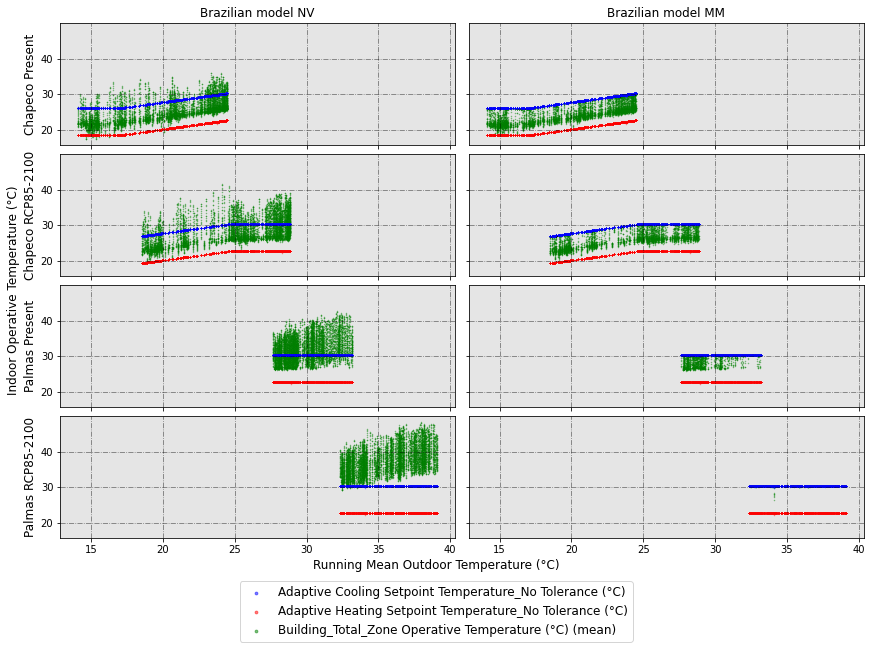

In [9]:
dataset_hourly.scatter_plot(
    vars_to_gather_rows=['EPW_City_or_subcountry', 'EPW_Scenario-Year'], # variables to gather in rows of subplots
    vars_to_gather_cols=['ComfMod', 'HVACmode'],# variables to gather in columns of subplots; all categorical columns which have more than 1 different value across the rows, must be specified in this argument, otherwise you'll get an error.
    detailed_cols=['CM_3[HM_1', 'CM_3[HM_2'], # a list of the specific combinations of arguments to be plotted joined by [
    data_on_x_axis='BLOCK1:ZONE2_ASHRAE 55 Running mean outdoor temperature (°C)', #column name (string) for the data on x axis
    data_on_y_main_axis=[ #list which includes the name of the axis on the first place, and then in the second place, a list which includes the column names you want to plot
        [
            'Indoor Operative Temperature (°C)',
            [
                'Adaptive Cooling Setpoint Temperature_No Tolerance (°C)',
                'Adaptive Heating Setpoint Temperature_No Tolerance (°C)',
                'Building_Total_Zone Operative Temperature (°C) (mean)',
            ]
        ],
    ],
    colorlist_y_main_axis=[
        [
            'Indoor Operative Temperature (°C)',
            [
                'b',
                'r',
                'g',
            ]
        ],
    ],
    rows_renaming_dict={
        'Chapeco[Present': 'Chapeco Present',
        'Chapeco[RCP85-2100': 'Chapeco RCP85-2100',
        'Palmas[Present': 'Palmas Present',
        'Palmas[RCP85-2100': 'Palmas RCP85-2100',
    },
    cols_renaming_dict={
        'CM_3[HM_1': 'Brazilian model NV',
        'CM_3[HM_2': 'Brazilian model MM',
    },
    supxlabel='Running Mean Outdoor Temperature (°C)', # data label on x axis
    figname='Scatterplot_NV_vs_MM',
    figsize=6,
    ratio_height_to_width=0.33,
    confirm_graph=True
)

In this figure, you can see on the left column the simulations with free-running (or naturally ventilated) mode, while on the right, the same simulations using mixed-mode with adaptive setpoint temperatures, which introduce all hourly indoor temperatures within the adaptive thermal comfort limits.

Next, let's compare the indoor temperatures of all idfs we have generated, and in this case, we're also going to plot the hourly energy demand on the main y axis, and the air renovation and operative temperature in 2 spines in the twin y axis.

In [ ]:
dataset_hourly.scatter_plot(
    vars_to_gather_cols=['ComfMod', 'HVACmode'], # variables to gather in rows of subplots
    vars_to_gather_rows=['EPW_City_or_subcountry', 'EPW_Scenario-Year'],# variables to gather in columns of subplots
    detailed_cols=['CM_0[HM_2', 'CM_3[HM_1', 'CM_3[HM_2'], #we only want to see those combinations
    custom_cols_order=['CM_3[HM_1', 'CM_0[HM_2', 'CM_3[HM_2'],
    data_on_x_axis='BLOCK1:ZONE2_ASHRAE 55 Running mean outdoor temperature (°C)', #column name (string) for the data on x axis
    data_on_y_main_axis=[ # similarly to above, a list including the name of the secondary y-axis and the column names you want to plot in it
        [
            'Energy (kWh/m2)',
            [
                'Building_Total_Cooling Energy Demand (kWh/m2) (summed)',
                'Building_Total_Heating Energy Demand (kWh/m2) (summed)',
            ]
        ],

    ],
    data_on_y_sec_axis=[ #list which includes the name of the axis on the first place, and then in the second place, a list which includes the column names you want to plot
        [
            'Air renovation (ach)',
            [
                'Building_Total_AFN Zone Infiltration Air Change Rate (ach) (summed)'
            ]
        ],
        [
            'Operative Temperature (°C)',
            [
                'Adaptive Cooling Setpoint Temperature_No Tolerance (°C)',
                'Adaptive Heating Setpoint Temperature_No Tolerance (°C)',
                'Building_Total_Zone Operative Temperature (°C) (mean)',
            ]
        ],
    ],
    colorlist_y_main_axis=[
        [
            'Energy (kWh/m2)',
            [
                'cyan',
                'orange',
            ]
        ],
    ],
    colorlist_y_sec_axis=[
        [
            'Air renovation (ach)',
            [
                'yellow'
            ]
        ],
        [
            'Operative Temperature (°C)',
            [
                'b',
                'r',
                'g',
            ]
        ],
    ],

    rows_renaming_dict={
        'Chapeco[Present': 'Chapeco Present',
        'Chapeco[RCP85-2100': 'Chapeco RCP85-2100',
        'Palmas[Present': 'Palmas Present',
        'Palmas[RCP85-2100': 'Palmas RCP85-2100',
    },
    cols_renaming_dict={
        'CM_3[HM_1': 'Brazilian adaptive NV',        
        'CM_0[HM_2': 'Brazilian static MM',
        'CM_3[HM_2': 'Brazilian adaptive MM',
    },
    supxlabel='Running Mean Outdoor Temperature (°C)', # data label on x axis
    figname=f'scatterplot_BRA_stat_BRA_adap_BRA_nv',
    figsize=6,
    ratio_height_to_width=0.33,
    confirm_graph=True
)

The number of rows and the list of these is going to be:
No. of rows = 4
List of rows:
Chapeco[Present
Chapeco[RCP85-2100
Palmas[Present
Palmas[RCP85-2100
The renamed rows are going to be:
Chapeco Present
Chapeco RCP85-2100
Palmas Present
Palmas RCP85-2100
The number of columns and the list of these is going to be:
No. of columns = 3
List of columns:
CM_3[HM_1
CM_0[HM_2
CM_3[HM_2
The renamed columns are going to be:
Brazilian adaptive NV
Brazilian static MM
Brazilian adaptive MM


Now, let's plot a similar figure to the first scatterplot, but showing the time in the x axis. In this case, we should use the method ``time_plot``:

In [ ]:
dataset_hourly.time_plot(
    vars_to_gather_rows=['EPW'], # variables to gather in rows of subplots
    vars_to_gather_cols=['ComfMod', 'HVACmode'],# variables to gather in columns of subplots; all categorical columns which have more than 1 different value across the rows, must be specified in this argument, otherwise you'll get an error.
    detailed_cols=['CM_3[HM_1', 'CM_3[HM_2'], # a list of the specific combinations of arguments to be plotted joined by [
    data_on_y_main_axis=[ #list which includes the name of the axis on the first place, and then in the second place, a list which includes the column names you want to plot
        [
            'Indoor Operative Temperature (°C)',
            [
                'Adaptive Cooling Setpoint Temperature_No Tolerance (°C)',
                'Adaptive Heating Setpoint Temperature_No Tolerance (°C)',
                'Building_Total_Zone Operative Temperature (°C) (mean)',
            ]
        ],
    ],
    colorlist_y_main_axis=[
        [
            'Indoor Operative Temperature (°C)',
            [
                'b',
                'r',
                'g',
            ]
        ],
    ],
    rows_renaming_dict={
        'Brazil_Chapeco_Present': 'Chapeco Present',
        'Brazil_Chapeco_RCP85-2100': 'Chapeco RCP85-2100',
        'Brazil_Palmas_Present': 'Palmas Present',
        'Brazil_Palmas_RCP85-2100': 'Palmas RCP85-2100',
    },
    cols_renaming_dict={
        'CM_3[HM_1': 'Brazilian model NV',
        'CM_3[HM_2': 'Brazilian model MM',
    },
    figname='Timeplot_NV_vs_MM',
    figsize=6,
    ratio_height_to_width=0.33,
    confirm_graph=True
)

### 3.2 Analysing the data

Now, let's see how many comfort hours there are, as well as the impact on energy demand. Since we want to see the runperiod totals, we will need to make a new instance of ``Table``, asking for runperiod frequency this time.

In [ ]:
from accim.data.data_postprocessing import Table
dataset_runperiod = Table(
    #datasets=list #Since we are not specifying any list, it will use all available CSVs in the folder
    source_frequency='hourly', # This lets accim know which is the frequency of the input CSVs. Input CSVs with multiple frequencies are also allowed. It can be 'hourly', 'daily', 'monthly' and 'runperiod'. It can also be 'timestep' but might generate errors.
    frequency='runperiod', # If 'daily', accim will aggregate the rows in days. It can be 'hourly', 'daily', 'monthly' and 'runperiod'. It can also be 'timestep' but might generate errors.
    frequency_agg_func='sum', #this makes the sum or average when aggregating in days, months or runperiod; since the original CSV frequency is in hour, it won't make any aeffect
    standard_outputs=True, 
    level=['building'], # A list containing the strings 'block' and/or 'building'. For instance, if ['block', 'building'], accim will generate new columns to sum up or average in blocks and building level.
    level_agg_func=['sum', 'mean'], # A list containing the strings 'sum' and/or 'mean'. For instance, if ['sum', 'mean'], accim will generate the new columns explained in the level argument by summing and averaging.
    level_excluded_zones=[],
    split_epw_names=True, #to split EPW names based on the pattern Country_City_RCPscenario-Year
)

dataset_runperiod.format_table(
    type_of_table='custom',
    custom_cols=[
        'Building_Total_Comfortable Hours_No Applicability (h) (mean)',
        'Building_Total_Total Energy Demand (kWh/m2) (summed)'
    ]
)

Let's see the dataframe we currently have:

In [ ]:
dataset_runperiod.df

Data is not easy to read like that, so let's make it clearer by using the ``wrangled_table`` method and passing ``multiindex`` in the ``reshaping`` argument:

In [ ]:
dataset_runperiod.wrangled_table(reshaping='multiindex')

dataset_runperiod.wrangled_df_multiindex

Now it's better, but we'd like to unstack the variables ComfMod and HVACmode, that is, move them from rows to columns:

In [ ]:
dataset_runperiod.wrangled_table(
    reshaping='unstack',
    vars_to_gather=['ComfMod', 'HVACmode'],
    rename_dict={
        'CM_0[HM_2': 'BRA_Stat_MM',
        'CM_3[HM_1': 'BRA_Adap_NV',
        'CM_3[HM_2': 'BRA_Adap_MM',
    }
)

dataset_runperiod.wrangled_df_unstacked

The table above shows us the comfort hours in NV (BRA_Adap_NV) mode ranges between 7389.50 and 48.92 hours, while the same comfort model in mixed-mode with adaptive setpoints (BRA_Adap_MM) ranges between 8712.00 and 8577.75. Since there is no HVAC system in NV mode, the energy consumption is 0. With adaptive setpoints, the hvac energy demand ranges between 235.10 and 945.55 (kWh/m2·year), while with the static setpoints it ranges between 771.65 and 1171.15.

But, what if we want to know the heating, cooling and total energy demand increase or decrease percentage of, for instance, BRA_Adap_MM, compared to the other combinations?

In [ ]:
dataset_runperiod.format_table(
    type_of_table='custom',
    custom_cols=[
        'Building_Total_Heating Energy Demand (kWh/m2) (summed)',
        'Building_Total_Cooling Energy Demand (kWh/m2) (summed)',
        'Building_Total_Total Energy Demand (kWh/m2) (summed)',
    ]
)

dataset_runperiod.wrangled_table(
    reshaping='unstack',
    vars_to_gather=['ComfMod', 'HVACmode'],
    
    baseline='CM_3[HM_2',
    comparison_mode=['baseline compared to others'],
    comparison_cols=['relative', 'absolute'],
    
    rename_dict={
        'CM_0[HM_2': 'BRA_Stat_MM',
        'CM_3[HM_1': 'BRA_Adap_NV',
        'CM_3[HM_2': 'BRA_Adap_MM',
    },
    transpose=True
)

dataset_runperiod.wrangled_df_unstacked

For instance, we can see the adaptive setpoints provide reductions in energy demand compared to the static setpoints ranging between 70 and 19%, depending on the scenarios and climate zones.

Now, we could finally export this table to Excel format for later style edition. Since the reshaping argument we used in the `wrangled_table()` method was 'unstack', the dataframe we are looking for to be exported is `dataset_runperiod.wrangled_df_unstacked`. If we used the 'pivot' argument, the dataframe would have been `dataset_runperiod.wrangled_df_pivoted`. So let's export it:

In [ ]:
dataset_runperiod.wrangled_df_unstacked.to_excel('df_unstacked.xlsx')

In [ ]:
import pandas as pd

df = pd.read_excel('df_unstacked.xlsx', header=[0, 1, 2], index_col=[0, 1])
df

Finally, so that we can run this jupyter notebook again, let's leave everything as it was at the beginning.

In [44]:
for i in original_epws:
    shutil.move(f'backup/{i}', i)

In [ ]:
files_to_delete = [i for i in listdir() if i not in input_files]

In [46]:
for i in files_to_delete:
    remove(i)